# Résolution d'un problème de flexion d'un poteau par éléments finis - Modèle de Bernoulli
Exemple vu en ED éléments finis - Mécanique des solides déformations 

@Arts et Métiers - Campus de Bordeaux

## Choix d’une modélisation
On souhaite étudier la tenue mécanique d’un poteau en acier (S185 galvanisé) soumis à l'action du vent.
Ce poteau fait une hauteur H. Il est tubulaire : sa section droite est circulaire et creuse, de rayon extérieur r et d’épaisseur e constants.

L'action du vent est modélisée par un efort linéique à ditribution linéaire : 
$\vec{f_l} = \frac{f_l}{H}x \vec{y}$ .
La liaison entre le poteau et le sol est modélisée par un encastrement.

On suppose que le matériau est homogène et isotrope. Ses propriétés élastiques sont données par le module d’Young $E$, le coefficient de Poisson $\nu$, et la limite d’élasticité $Re$. Sa masse volumique est notée $\rho$.
Le cadre d’application est celui des Petites Perturbations.

Données : $H$ = 5m, $r$ = 15cm, $e$ = 5mm, $E$ = 210GPa, $\nu$ = 0.285, $Re$ = 185MPa, $\rho$ = 7850kg/m3.

Remarque : 
* Dans le code, certains paramètres sont définis comme des fonctions pour pouvoir les remplacer par des valeurs variables le long de la poutre. 
* Plusieurs conditions de chargement ont été prédéfinies. Le cas de chargement peut être modifié en changeant la variable 'LoadCondition'.


In [78]:
import numpy as np
from matplotlib import pylab as plt

H = 3
E = 1e3 #Young Modulus
nu = 0.3 #poisson Ratio

# the following function are given in function of the global coordinate x
def r(x): return 0.1 # Constant section radius
#def r(x): return 0.20*(1-x/H)+ 0.10*x/H # Variale section radius
def e(x): return 0.1 #Section thickness
def S(x): return np.pi * (r(x)**2 - (r(x)-e(x))**2)  #Section Area
def I(x): return np.pi/4 * (r(x)**4 - (r(x)-e(x))**4)  #Section Area

LoadCondition = 2
if LoadCondition == 0:
    #Constant lineic force    
    F = 0
    def fl(x): return -100 #lineic force 
elif LoadCondition == 1: 
    #Variable lineic force (with constant derivative)
    F = 0
    def fl(x): 
        a = 100/H ; b = 0
        return a*x+b
elif LoadCondition == 2: 
    F=-1 #point force at the high end of the beam
    #node force on the top extremity
    def fl(x): return 0        


## Choix d'une discrétisation
Afin de résoudre ce problème par la méthode des éléments finis, on choisit de discrétiser la poutre ci-dessus en 3 éléments de longueur L identiques : poutres à deux nœuds en flexion avec 2 degrés de liberté par noeud (déplacement $v$ suivant $y$ et rotation $\theta$ suivant $\vec{z}$).
Il y aura ainsi 4 noeuds au total. La position des noeuds suivant $\vec{x}$ est déterminé avec la fonction linspace de numpy.

In [79]:
xmin = 0
xmax = H
NumberOfElements = 1

#2 nodes beam 
NumberOfNodes = NumberOfElements + 1
    
NodeCoordinates = np.linspace(xmin,xmax,NumberOfNodes)
print(NodeCoordinates)

[0. 3.]


Pour définir les 3 éléments, il convient de créer une matrice de connection dont les lignes sont les numéros des noeuds appartenant aux éléments (nombre de lignes = nombre d'éléments)

In [80]:
ConnectionMatrix = np.c_[(np.arange(NumberOfNodes-1), np.arange(1,NumberOfNodes))]  
print(ConnectionMatrix)

[[0 1]]


## Champs de déplacement de déformation et de contraintes approchés 
### Interpolation du champ de déplacement
Pour la méthode des éléments finis, il faut commencer par définir une fonction d'interpolation sur chaque élément.
Pour un élément poutre de Bernoulli en flexion à 2 noeuds, de longueur $L$ sur l'intervale $[0,L]$, le champ de déplacement suivant est interpolé par : 
$$v(\xi) = \left[ \begin{matrix} \frac{2}{L^3}\xi^3 - \frac{3}{L^2} \xi^2 + 1 & -\frac{2}{L^3}\xi^3 + \frac{3}{L^2} \xi^2 & \frac{1}{L^2}\xi^3 - \frac{2}{L} \xi^2 + \xi & \frac{1}{L^2}\xi^3 - \frac{1}{L} \xi^2 \end{matrix} \right] . \left[ \begin{matrix} v_i \\ v_j \\ \theta_i \\ \theta_j \end{matrix} \right] = N(\xi) . q_{el}$$
$\xi$ est la coordonnée définie dans le repère élémentaire. Pour passer du repère élémentaire au repère gobal, il suffit de faire le changement de variable $x = \xi+x_0$ avec $x_0$ l'absisse de l'origine du repère élémentaire.

La fonction $N(\xi, L)$ est donc créée pour l'interpolation du champ de déplacement. Si $\xi$ et $L$ sont des scalaires, $N(\xi, L)$ renvoie une matrice ligne. Si $\xi$ est un numpy array de dimension 1, $N$ retourne un tableau de dimension 3 contenant toutes les valeurs de $N$ pour les position $\xi$ données.

In [81]:
def N(xi,L):
    # element coordinate xi
    # shape function for vi, vj, theta i, theta j between 0 and L
    return np.array([[2/L**3*xi**3 - 3/L**2*xi**2 +1 ,                            
                      -2/L**3*xi**3 + 3/L**2*xi**2 ,
                      1/L**2*xi**3 - 2/L*xi**2 + xi,
                      1/L**2*xi**3 - 1/L*xi**2]])

### Visualisations les fonctions de forme en utilisant la fonction plot de matplotlib. 

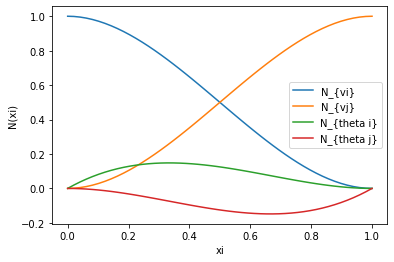

In [82]:
NumberOfPointsToPlot = 50
L=1
xi = np.linspace(0, L, NumberOfPointsToPlot)
plt.figure()
plt.plot(xi, N(xi,L)[0,0,:], label='N_{vi}')
plt.plot(xi, N(xi,L)[0,1,:], label='N_{vj}')
plt.plot(xi, N(xi,L)[0,2,:], label='N_{theta i}')
plt.plot(xi, N(xi,L)[0,3,:], label='N_{theta j}')

plt.xlabel('xi')
plt.ylabel('N(xi)')
plt.legend()


### Interpolation des déformations et contraintes
Pour un élément poutre en flexion avec l'hypothèse de Bernoulli (contraintes de cisaillement négligés), la seule déformation généralisée utile est la courbure de la poutre $\gamma(x) = \frac{d\theta}{dx}(x) = \frac{d^2 v}{dx^2}(x) $.
$$\frac{d^2 v}{dx^2}(\xi) = \left[ \begin{matrix} \frac{12}{L^3}\xi - \frac{6}{L^2} & -\frac{12}{L^3}\xi + \frac{6}{L^2} & \frac{6}{L^2}\xi - \frac{4}{L} & \frac{6}{L^2}\xi - \frac{2}{L} \end{matrix} \right] . \left[ \begin{matrix} v_i \\ v_j \\ \theta_i \\ \theta_j \end{matrix} \right] = B(\xi) . q_{el}$$

Pour en déduire le moment fléchissant dans la poutre, il convient d'utiliser la loi de comportement généralisée :
$M_f = EI \gamma$

Nous définissons donc les fonction matricielles 'B' et 'StressMatrix' respectivement pour l'interpolation des déformations et des contraintes généralisées (moment fléchissant).

In [83]:
def B(xi, L):
    #return N''
    return  np.array([[12/L**3*xi - 6/L**2 ,                            
                      -12/L**3*xi + 6/L**2 ,
                      6/L**2*xi - 4/L ,
                      6/L**2*xi - 2/L]])
    
def StressMatrix(xi, L, x0, E, I):
    x = xi+x0 #change of variable: local coordinate is transform into global coordinate to use the function S
    #return flexural moment    
    return E*I(xi+x0)*B(xi,L)

Remarque : le changement de variable $x = \xi+x_0$ est appliqué au moment quadratique pour passer du repère global au repère élémentaire.

## Matrice de rigidité élémentaire
Pour calculer la matrice de rigidité élémentaire $K_{el}$, il faut revenir à la définition de l'énergie élastique.
Pour des éléments poutres en flexion : 
$$E_d = \frac{1}{2} \int_{0}^{L} M_f(\xi) \gamma(\xi) \, d\xi$$
Et donc en utilisant les interpolations de $\gamma$ et $M_f$ :
$$E_d = q_{el}^T \, \frac{1}{2} \underbrace{\left( \int_{0}^{L} EI \, B(\xi,L)^T . B(\xi,L) \, d\xi \right)}_{K_{el}} \, q_{el} $$

On commence par définir une fonction pour l'intégration basée sur la méthode des trapèzes dans un soucis de simplicité.

In [84]:
NumberOfIntegrationPoints = 10000

def integrate(f, a, b, N):
    x = np.linspace(a, b, N)
    fx = f(x)
    area = np.sum(fx,axis = 0)*(b-a)/N
    return area

Nous avons vu que $K_{el} = \int_{0}^{L} dE(\xi,L,E,I) \, d\xi$
avec $dE = EI \, B(\xi,L)^T . B(\xi,L)$.

Nous définons donc la fonction dE que nous intégrons numériquement entre $0$ et $L$.
Ces 2 étapes sont inclus dans la fonction GetElementStiffnessMatrix qui renvoit la matrice de rigidité $K_{el}$.

In [85]:
def GetElementStiffnessMatrix(L, x0, E, I, NumberOfIntegrationPoints):
    def dE(xi):        
        Sigma = np.transpose( StressMatrix(xi,L,x0,E,I) , (2,1,0) )
        Epsilon = np.transpose( B(xi,L) , (2,0,1) )
        return Sigma @ Epsilon #@ operator = stack of matrix multiplication
    
    return integrate(dE,0,L, NumberOfIntegrationPoints)

Kel = GetElementStiffnessMatrix(L,0,E,I,NumberOfIntegrationPoints)
print(Kel)

[[ 0.94266631 -0.94266631  0.47133316  0.47133316]
 [-0.94266631  0.94266631 -0.47133316 -0.47133316]
 [ 0.47133316 -0.47133316  0.31420639  0.15712676]
 [ 0.47133316 -0.47133316  0.15712676  0.31420639]]


In [86]:
Kel = GetElementStiffnessMatrix(L,0,E,I,NumberOfIntegrationPoints)
print(Kel)

[[ 0.94266631 -0.94266631  0.47133316  0.47133316]
 [-0.94266631  0.94266631 -0.47133316 -0.47133316]
 [ 0.47133316 -0.47133316  0.31420639  0.15712676]
 [ 0.47133316 -0.47133316  0.15712676  0.31420639]]


## Assemblage de la matrice de rigidité globale

L'assemblage de la matrice globale se fait simplement avec une boucle sur les éléments en ajoutant la contribution de chaque élément aux noeuds correspondants. 

In [87]:
#Assemble the global stiffness matrix
NumberOfDOF = 2*NumberOfNodes #2 dof per node: 2 displacements and 2 rotations
StiffnessMatrix = np.zeros((NumberOfDOF, NumberOfDOF)) 
for element in range(NumberOfElements):
    Nodes = ConnectionMatrix[element]   
    Crd = NodeCoordinates[Nodes]
    L = Crd[-1] - Crd[0]    
    x0 = Crd[0]
    DOF = np.hstack((Nodes, Nodes+NumberOfNodes)) #Degree of freedom: 2 displacements and 2 rotations
    Kel = GetElementStiffnessMatrix(L,x0,E,I,NumberOfIntegrationPoints) 
    StiffnessMatrix[DOF.reshape(-1,1), DOF] += Kel   

print(StiffnessMatrix)

[[ 0.03491357 -0.03491357  0.05237035  0.05237035]
 [-0.03491357  0.03491357 -0.05237035 -0.05237035]
 [ 0.05237035 -0.05237035  0.10473546  0.05237559]
 [ 0.05237035 -0.05237035  0.05237559  0.10473546]]


## Matrice colonne des efforts généralisés


Pour les efforts généralisées, on distingue les efforts ponctuels aux noeuds des efforts linéiques.
On commence par initialiser un vecteur 'ForceVector' contenant uniquement les efforts aux noeuds (ici, un seul effort ponctuel sur le dernier noeuds (noeud 4). 

In [88]:
ForceVector = np.zeros(NumberOfDOF)
ForceVector[NumberOfNodes-1] = F

Pour les efforts linéiques, il faut revenir à la définition du travail des efforts exterieurs sur un élément. 
$$W_{ext} = \int_{0}^{L} f_l(x) v(\xi) \, d\xi$$
Et donc en utilisant l'interpolation de $v(x)$:
$$W_{ext} = q_{el}^T \, \underbrace{\left( \int_{0}^{L} N(\xi,L)^T . f_l(\xi+x_0) \, d\xi \right)}_{F_{el}}  $$

Comme pour la matrice de rigidité globale, nous définissons une fonction $dF = N(\xi,L)^T . f_l(\xi+x0)$ que nous intégrons sur chaque élément pour avoir $F_{el}$, puis nous sommons les contributions de chaque éléments dans une matrice colonne globale (matrice des efforts généralisés). 

In [89]:
#Assemble force vector
for element in range(NumberOfElements):
    Nodes = ConnectionMatrix[element]   
    Crd = NodeCoordinates[Nodes]
    L = Crd[-1] - Crd[0]
    x0 = Crd[0]
    DOF = np.hstack((Nodes, Nodes+NumberOfNodes)) #Degree of freedom: 2 displacements and 2 rotations

    def dF(xi):
        return (fl(xi+x0)*N(xi,L)[0]).T
        
    Fel = integrate(dF, 0, L, NumberOfIntegrationPoints)
    ForceVector[DOF] += Fel #[0]  
    
print(ForceVector)

[ 0. -1.  0.  0.]


## Conditions aux limites et résolution
On définit une matrice G telle que les conditions aux limites s'écrivent : $G q = Q_d$.
Ici nous avons uniquement le premier noeud (noeud 0) qui est bloqué : $v_0=\theta_0=0$.

In [90]:
G = np.zeros((2,NumberOfDOF))
G[0,0] = G[1, NumberOfNodes] = 1
Qd = np.array([0,0]) 
print(G)
print(Qd)




[[1. 0. 0. 0.]
 [0. 0. 1. 0.]]
[0 0]


On construit ensuite le système à résoudre : $M q = V$. 
Les conditions aux limites sont appliquées avec la méthode des multiplicateurs de Lagrange.

In [91]:
nbCL = np.shape(G)[0]
M = np.block([[StiffnessMatrix, -G.T],[G, np.zeros((nbCL, nbCL))]])
#print(M)

In [92]:
V = np.block([ForceVector, Qd])
#print(V)

le système est résolu par une méthode directe (pivot de Gauss). Pour les grands systèmes creux, l'utilisation d'une méthode itérative est en général plus efficace. 

In [93]:
nbCL = np.shape(G)[0]
M = np.block([[StiffnessMatrix, -G.T],[G, np.zeros((nbCL, nbCL))]])
print(M)
V = np.block([ForceVector, Qd])
print(V)

res  = np.linalg.solve(M, V)
U = res[:NumberOfNodes]
Theta= res[NumberOfNodes:2*NumberOfNodes]
R = res[2*NumberOfNodes:]
print(U) #Nodal displacement
#print(Theta) #Nodal rotation 
#print(R) #Force and Moment Reaction

[[ 0.03491357 -0.03491357  0.05237035  0.05237035 -1.         -0.        ]
 [-0.03491357  0.03491357 -0.05237035 -0.05237035 -0.         -0.        ]
 [ 0.05237035 -0.05237035  0.10473546  0.05237559 -0.         -1.        ]
 [ 0.05237035 -0.05237035  0.05237559  0.10473546 -0.         -0.        ]
 [ 1.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          1.          0.          0.          0.        ]]
[ 0. -1.  0.  0.  0.  0.]
[   0.         -114.58583002]


## Visualisation
### Visualisation du déplacement


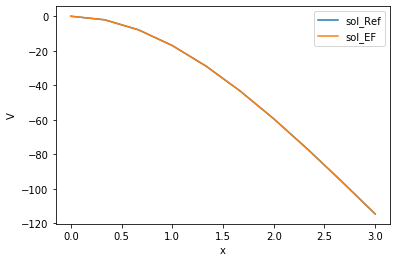

In [94]:
#Reference solution (only for constant section)
x = np.linspace(0, H, 10*NumberOfElements)
if LoadCondition == 0:
    plt.plot(x, fl(x)*((H-x)**4 + 4*H**3*x-H**4)/(24*E*I(x)), label='sol_Ref')
#elif LoadCondition == 1:
#    plt.plot(x, fl(x)*x**2*(20*H**3-10*H**2*x+x**3)/(120*E*I(x)*H), label='sol_Ref')
elif LoadCondition == 1:
    a = (fl(H)-fl(0))/H ; b = fl(0)
    plt.plot(x, (a/120*x**5 + b/24*x**4 - (a*H**2/12+b*H/6)*x**3 + (a*H**3/6 + b*H**2/4)*x**2)/(E*I(x)), label='sol_Ref')
elif LoadCondition == 2: 
    plt.plot(x, F*x**2*(3*H-x)/(6*E*I(x)), label='sol_Ref')

#FE solution
xi = np.linspace(0, L, 10)
x_all = []
u_y = []
for element in range(NumberOfElements):
    Nodes = ConnectionMatrix[element] 
    DOF = np.hstack((Nodes, Nodes+NumberOfNodes)) #Degree of freedom: 2 displacements and 2 rotations
    Crd = NodeCoordinates[Nodes]
    L = Crd[-1]-Crd[0]
    x = np.linspace(Crd[0], Crd[-1], 10)
    u_y = np.hstack((u_y, (N(xi, L).transpose(2,0,1)@res[DOF])[:,0]))
    x_all = np.hstack((x_all, x))

plt.plot(x_all, u_y, label='sol_EF')
plt.xlabel('x')
plt.ylabel('V')
plt.legend()


### Visualisation du moment de flexion

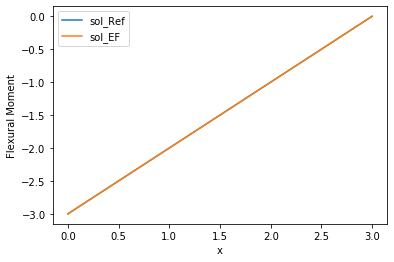

In [95]:
#Reference solution (only for constant section)
x = np.linspace(0, H, 10*NumberOfElements)
if LoadCondition == 0:
    plt.plot(x, fl(x)*12*(H-x)**2/24, label='sol_Ref')
       
elif LoadCondition == 1:
    a = (fl(H)-fl(0))/H ; b = fl(0)
    plt.plot(x, a/3*(H**3-x**3) + (b-a*x)/2*(H**2-x**2) - x*b*(H-x), label='sol_Ref')

elif LoadCondition == 2: 
    plt.plot(x, F*(H-x) , label='sol_Ref')


#FE solution
xi = np.linspace(0, L, 10)
x_all = []
sigma_x = []
for element in range(NumberOfElements):
    Nodes = ConnectionMatrix[element]   
    DOF = np.hstack((Nodes, Nodes+NumberOfNodes)) #Degree of freedom: 2 displacements and 2 rotations    
    Crd = NodeCoordinates[Nodes]
    L = Crd[-1]-Crd[0]
    x0 = Crd[0]
    x = np.linspace(Crd[0], Crd[-1], 10)
    sigma_x = np.hstack((sigma_x, (StressMatrix(xi, L,x0,  E, I).transpose(2,0,1)@res[DOF])[:,0]))
    x_all = np.hstack((x_all, x))

plt.plot(x_all, sigma_x, label='sol_EF')
plt.xlabel('x')
plt.ylabel('Flexural Moment')
plt.legend()

## Pour aller plus loin
* Modifier le nombre de noeuds et relancer le calcul pour observer la convergence des résultats vers la solution analytique.